<a href="https://colab.research.google.com/github/kozoB/unsupervised-feature-extraction-of-aerial-images-for-clustering/blob/main/Unsupervised_Feature_Extraction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Feature Extraction of Aerial Images for Clustering

This project implements the core method from the paper “Unsupervised feature extraction of aerial images for clustering and understanding hazardous road segments” using the Aerial Imagery Semantic Segmentation Dataset from Kaggle. The goal is to learn unsupervised latent features from aerial images that capture differences in the built environment - such as roads, residential areas, natural landscapes, and infrastructure - and to cluster these images into meaningful groups without any labels. We load and preprocess the images, train a convolutional autoencoder to learn compressed feature representations, reduce the features with PCA, and perform Agglomerative Clustering to identify visually and semantically coherent categories of urban form, reproducing the paper’s feature extraction and clustering pipeline on a different open aerial imagery dataset

## Retrieve Dataset From Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d ransakaravihara/aerial-imagery-semantic-segmentation-dataset
!unzip aerial-imagery-semantic-segmentation-dataset.zip -d aerial_data

## Load Dataset

In [3]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# set image directory
image_dir = 'aerial_data/images'

# get all image paths
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

print(f"Found {len(image_paths)} images")

# Load and preprocess
def load_image(path, size=(128,128)):
    img = Image.open(path).convert('RGB')
    img = img.resize(size)
    return np.array(img) / 255.0

images = np.array([load_image(p) for p in image_paths])

print(f"Shape of dataset: {images.shape}")

Found 1305 images
Shape of dataset: (1305, 128, 128, 3)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Encoder
input_img = layers.Input(shape=(128,128,3))
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(128, activation='relu')(x)

# Decoder
x = layers.Dense(32*32*64, activation='relu')(encoded)
x = layers.Reshape((32,32,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

# Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 65536)          │     8,454,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,918,531 (64.54 MB)

 Trainable params: 16,918,531 (64.54 MB)

 Non-trainable params: 0 (0.00 B)

## Train The Encoder

In [5]:
autoencoder.fit(images, images,
                epochs=20,
                batch_size=16,
                validation_split=0.1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0750 - val_loss: 0.0537
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0540 - val_loss: 0.0468
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0488 - val_loss: 0.0439
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0462 - val_loss: 0.0406
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0420 - val_loss: 0.0386
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0410 - val_loss: 0.0367
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0388 - val_loss: 0.0349
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0366 - val_loss: 0.0335
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0347 - val_loss: 0.0323
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0319 - val_loss: 0.0324
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0322 - val_loss: 0.0307
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.

## Ectract Latent Features

In [6]:
encoder = models.Model(input_img, encoded)
latent_features = encoder.predict(images)
print(latent_features.shape)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
(1305, 128)


## Reduce Dimensions with PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
reduced_features = pca.fit_transform(latent_features)
print(reduced_features.shape)

(1305, 10)


## Cluster with Agglomerative Clustering

In [8]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4)
cluster_labels = clustering.fit_predict(reduced_features)

print(np.unique(cluster_labels))

[0 1 2 3]


## Visualize Clusters


Cluster 0


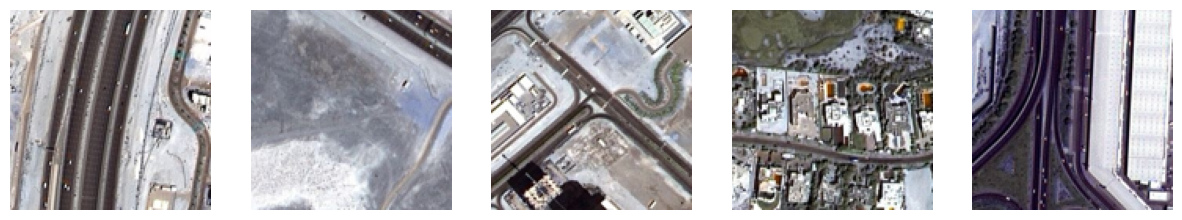


Cluster 1


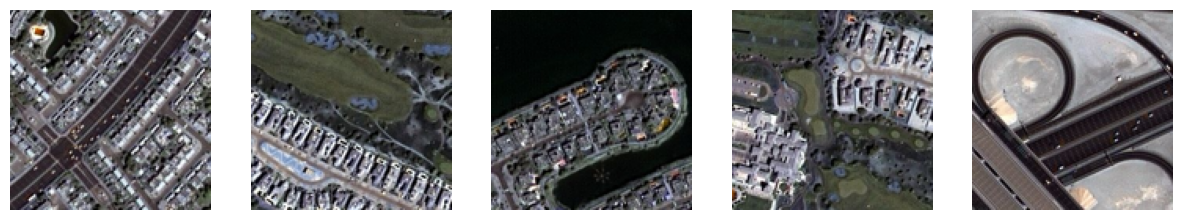


Cluster 2


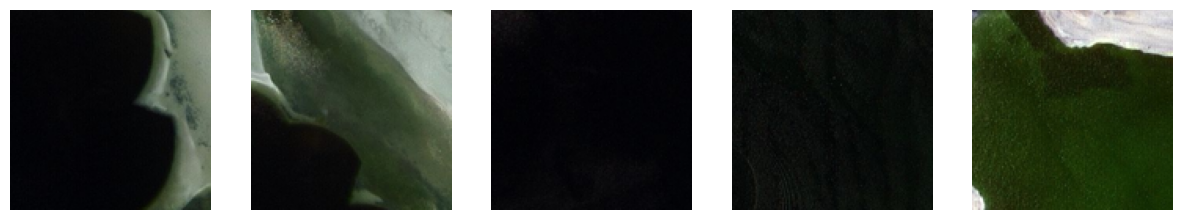


Cluster 3


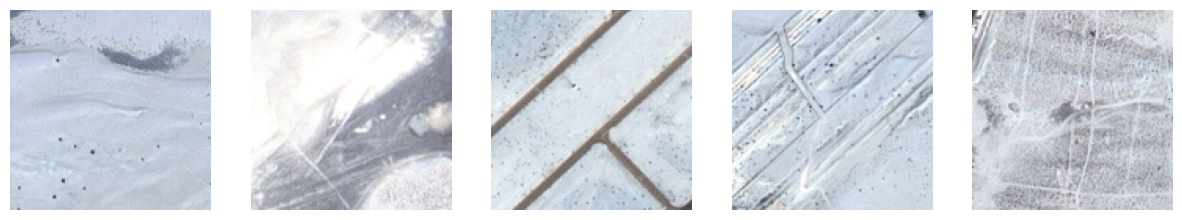

In [9]:
import random

for cluster in np.unique(cluster_labels):
    print(f"\nCluster {cluster}")
    cluster_indices = np.where(cluster_labels == cluster)[0]
    sample_indices = random.sample(list(cluster_indices), min(5, len(cluster_indices)))

    plt.figure(figsize=(15,3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1,5,i+1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.show()